# Tutorial: Forecasting Github Daily Active Users

In this notebook, we show how to use Deep4Cast to forecast a single time series of Github daily active users. The data can be gathered from [Github Archive](https://www.gharchive.org/) and is entirely public. The idea here is to show how to handle a short timeseries with many characteristics, e.g., positive values, trending, multiple seasonalities, etc.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

from deep4cast.forecasters import Forecaster
from deep4cast.models import WaveNet
from deep4cast.time_series_dataset import TimeSeriesDataset
from deep4cast.transforms import RemoveLast, Tensorize, Target
import deep4cast.metrics as metrics

# Make RNG predictable
np.random.seed(0)
torch.manual_seed(0)
# Use a gpu if available, otherwise use cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

## Forecasting parameters

We first need to specify how much history to use in creating a forecast of a given length:

- horizon = time steps (days) to forecast
- lookback = time steps (days) leading up to the period to be forecast

In [2]:
horizon = 90
lookback = 256

## Dataset

### Loading and visualization
The data set consists of only one time series, Github daily active users, that we want to model.

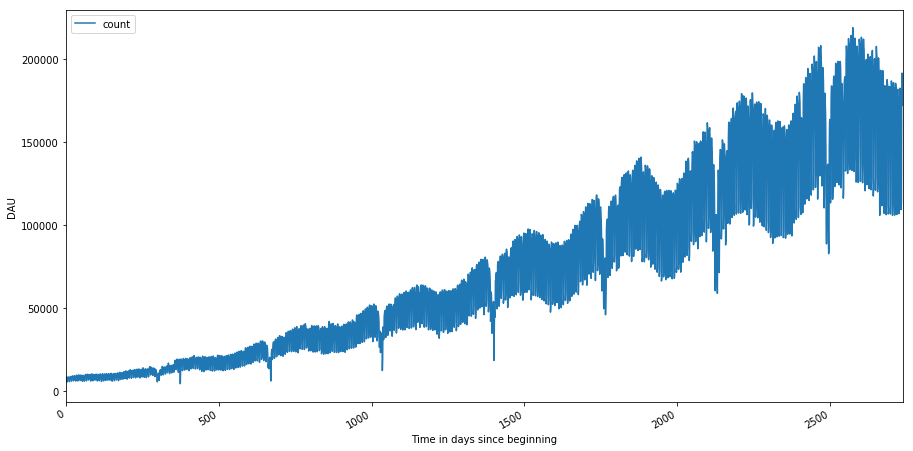

In [3]:
# If the data doesn't exist then run the processing script
if not os.path.isfile('./data/processed/github_dau_2011-2018.pkl'):
    %run data/process_github.py --data_path data/raw/github_dau_2011-2018.csv --output_path data/processed/github_dau_2011-2018.pkl
# Load the dataset
data = pd.read_pickle("./data/processed/github_dau_2011-2018.pkl")

# Plot the data to help our imaginations
data[['count']].apply(np.expm1).plot(subplots=True, figsize=(15, 8))
plt.xlabel('Time in days since beginning')
plt.ylabel('DAU')
plt.show()

### Divide into train and test

In [4]:
# Calculate training & testing boundary
test_ind = data[data['date'] == dt.datetime(2017,6,4)].index[0]
data = data.set_index('date')
data_arr = data.values
data_arr = np.expand_dims(data_arr.T, 0) # Get array into right shape for chunking

# Sequentialize the training and testing dataset
data_train, data_test = [], []
for time_series in data_arr:
    data_train.append(time_series[:, :test_ind],)
    data_test.append(time_series[:, test_ind-lookback:])
data_train = np.array(data_train)
data_test = np.array(data_test)

We follow [Torchvision](https://pytorch.org/docs/stable/torchvision) in processing examples using [Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) chained together by [Compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose).

* `Tensorize` creates a tensor of the example.
* `RemoveLast` subtracts the final value in the `lookback` from both `lookback` and `horizon`.
* `Target` specifies which index in the array is to be forecasted.

In [5]:
# Bring into Pytorch Dataset framework
transform = Compose(
    [Tensorize(), 
     RemoveLast(targets=[0]), 
     Target(targets=[0])]
)

`TimeSeriesDataset` inherits from [Torch Datasets](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for use with [Torch DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). It handles the creation of the examples used to train the network using `lookback` and `horizon` to partition the time series.

In [6]:
data_train = TimeSeriesDataset(
    data_train, 
    lookback, 
    horizon, 
    transform=transform
)
data_test = TimeSeriesDataset(
    data_test, 
    lookback, 
    horizon, 
    step=horizon, 
    transform=transform
)

# Create mini-batch data loader
dataloader_train = DataLoader(
    data_train, 
    batch_size=32, 
    shuffle=True, 
    pin_memory=True,
    num_workers=1
)
dataloader_test = DataLoader(
    data_test, 
    batch_size=3, 
    shuffle=False
)

## WaveNet
Our network architecture is based on ideas related to WaveNet (see references). We employ the same architecture with a few modifications (e.g., a fully connected output layer for vector forecasts). It turns out that we do not need many layers in this example to achieve state-of-the-art results, most likely because of the simple autoregressive nature of the data.

![architecture](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif)

In many ways, a temporal convoluational architecture is among the simplest possible architecures that we could employ using neural networks. In our approach, every layer has the same number of convoluational filters and uses residual connections.

In [7]:
# Define the model architecture
n_layers = 6
model = WaveNet(input_channels=21,
                output_channels=1,
                horizon=horizon, 
                n_layers=n_layers)

# .. and the optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

# .. and the loss
loss = torch.distributions.Normal

print('Number of model parameters: {}.'.format(model.n_parameters))

print('Receptive field size: {}.'.format(model.receptive_field_size))

Number of model parameters: 116734.
Receptive field size: 64.


In [8]:
# Fit the forecaster
forecaster = Forecaster(model, loss, optim, n_epochs=10, device=device)
forecaster.fit(dataloader_train, eval_model=True)

Number of model parameters being fitted: 116734.
Epoch 1/10 [1940/1940 (98%)]	Loss: 0.043966	Elapsed/Remaining: 0m3s/0m31s   
Training error: 7.59e+00.
Epoch 2/10 [1940/1940 (98%)]	Loss: -0.156904	Elapsed/Remaining: 0m8s/0m32s   
Training error: -2.01e+01.
Epoch 3/10 [1940/1940 (98%)]	Loss: -0.342942	Elapsed/Remaining: 0m12s/0m29s   
Training error: -3.69e+01.
Epoch 4/10 [1940/1940 (98%)]	Loss: -0.732276	Elapsed/Remaining: 0m17s/0m25s   
Training error: -4.65e+01.
Epoch 5/10 [1940/1940 (98%)]	Loss: -0.605564	Elapsed/Remaining: 0m21s/0m21s   
Training error: -4.94e+01.
Epoch 6/10 [1940/1940 (98%)]	Loss: -0.755581	Elapsed/Remaining: 0m26s/0m17s   
Training error: -5.78e+01.
Epoch 7/10 [1940/1940 (98%)]	Loss: -0.557254	Elapsed/Remaining: 0m30s/0m13s   
Training error: -6.28e+01.
Epoch 8/10 [1940/1940 (98%)]	Loss: -0.752728	Elapsed/Remaining: 0m35s/0m9s    
Training error: -6.74e+01.
Epoch 9/10 [1940/1940 (98%)]	Loss: -0.862031	Elapsed/Remaining: 0m39s/0m4s   
Training error: -7.05e+01.
Ep

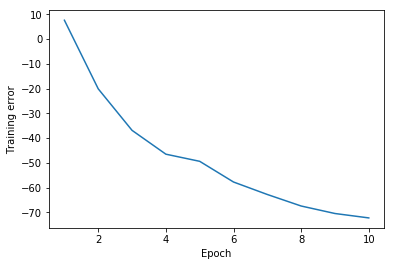

In [9]:
# Let's plot the training error
plt.plot(range(1, forecaster.n_epochs+1), forecaster.history['training'])
plt.xlabel('Epoch')
plt.ylabel('Training error')
plt.show()

## Evaluation
Before any evaluation score can be calculated, we need to transform the output forecasts.

In [10]:
# Get time series of actuals for the testing period
y_test_actual_raw, y_test_actual_offset = [], []
for sample in dataloader_test:
    y_test_actual_raw.append(sample['y'].cpu().numpy())
    y_test_actual_offset.append(sample['RemoveLast_offset'].cpu().numpy())
y_test_actual_raw = np.concatenate(y_test_actual_raw, axis=0)
y_test_actual_offset = np.concatenate(y_test_actual_offset, axis=0)
y_test_actual = y_test_actual_raw + y_test_actual_offset[:, :, None]

y_test_actual = np.reshape(y_test_actual, y_test_actual.shape[0]*y_test_actual.shape[2])
y_test_actual = np.expm1(y_test_actual)

# Get corresponding predictions
# The samples are of the shape (n_samples, n_series, n_covariates, n_timesteps), whereas the actuals are of the shape
# (n_series, n_covariates, n_timesteps)
raw_samples = forecaster.predict(dataloader_test, n_samples=100)
y_test_samples = []
for i in range(raw_samples.shape[1]):
    y_test_samples.append(raw_samples[:,i,:] + y_test_actual_offset[i])
        
y_test_samples = np.concatenate(y_test_samples, axis=-1)
y_test_samples = np.expm1(y_test_samples)

y_test_mean = np.mean(y_test_samples, axis=0)
y_test_lq = np.percentile(y_test_samples, q=5, axis=0)
y_test_uq = np.percentile(y_test_samples, q=95, axis=0)

We calculate the [symmetric MAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) and [pinball loss](https://www.lokad.com/pinball-loss-function-definition), as well as the empirical coverage for the test set data.

SMAPE: 7.031%


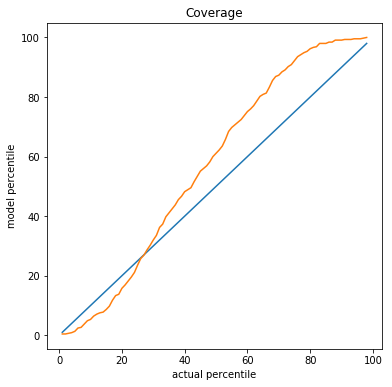

In [11]:
# Evaluate forecasts
test_smape = metrics.smape(y_test_samples, y_test_actual)
test_perc = np.arange(1, 99)
test_cov = metrics.coverage(y_test_samples, y_test_actual, percentiles=test_perc)

print('SMAPE: {}%'.format(test_smape))

plt.figure(figsize=(6, 6))
plt.plot(test_perc, test_perc)
plt.plot(test_perc, test_cov)
plt.xlabel('actual percentile')
plt.ylabel('model percentile')
plt.xlabel('actual percentile')
plt.ylabel('model percentile')
plt.title('Coverage')
plt.show()

Let's have a closer look at what a forecast looks like. We can use the model output to graph the mean, 95th and 5th percentiles. We'll also graph the actuals for comparison.

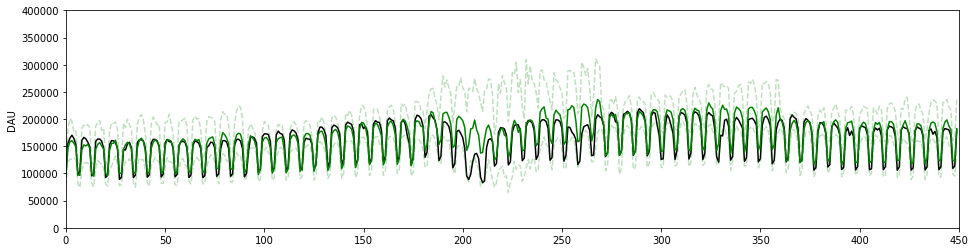

In [12]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(16, 4))

plt.plot(y_test_actual, 'k-')
plt.plot(y_test_mean.T, 'g-')
plt.plot(y_test_uq.T, 'g--', alpha=0.25)
plt.plot(y_test_lq.T, 'g--', alpha=0.25)

plt.ylim([0, 0.4e6])
plt.xlim([0, y_test_actual.shape[-1]])

plt.ylabel('DAU')
plt.show()

## References
[WaveNet Paper](https://arxiv.org/abs/1609.03499)

[Comparison of CNNs to RNNs for sequence modeling](https://arxiv.org/abs/1803.01271)

[Conditional time series forecasting with CNNs](https://arxiv.org/abs/1703.04691)